In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
run = 1

In [17]:
mid_prices = pd.read_csv(f'/Users/admin/Workspace/apxr/output/apxr_mid_prices{run}.csv', header=None)
mid_prices.columns = ['price']
mid_prices['returns'] = mid_prices['price'].pct_change()

In [18]:
trade_prices = pd.read_csv(f'/Users/admin/Workspace/apxr/output/apxr_trades{run}.csv', header=None)
trade_prices.columns = ['price']
trade_prices['returns'] = trade_prices["price"].pct_change()

## Fat tailed distribution of returns

In [21]:
time = []
kurt = []

for lag in range(2500):
    lagged_returns = trade_prices['price'].pct_change(lag)
    kurtosis = lagged_returns.kurt()
    kurt.append(kurtosis)
    time.append(lag)

# Remove first observation since it is zero and Nan
time = time[1:]
kurt = kurt[1:]

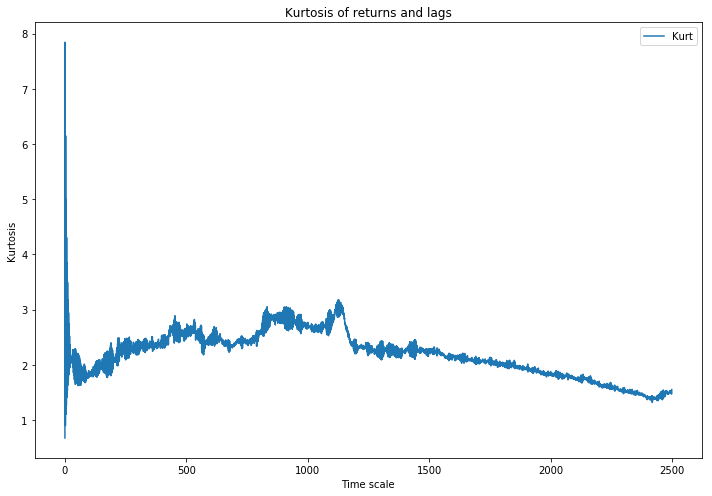

In [22]:
plt.figure(figsize=(10, 7))

plt.plot(time, kurt, label='Kurt')
plt.legend()
plt.xlabel('Time scale')
plt.ylabel('Kurtosis')
plt.title('Kurtosis of returns and lags')
plt.tight_layout()

## Volatility clustering

In [ ]:
import sys
!{sys.executable} -m pip install hurst

In [ ]:
from hurst import compute_Hc

H_list = []

for lag in range(1, 2500):
    H, c, data = compute_Hc(np.cumsum(mid_prices["price"].pct_change(lag).dropna().abs()), kind='random_walk', simplified=True)
    H_list.append(H)

In [ ]:
f, ax = plt.subplots(figsize=(10, 7))
plt.plot(np.arange(2499), H_list)
ax.set_xlabel('Time interval')
ax.set_ylabel('Hurst exponent')
ax.grid(True)
plt.title('Volatility clustering')
plt.show()

## Autocorrelation of returns

In [ ]:
def autocorrelation(x):
    result = np.correlate(x, x, mode='full')
    return result[int(len(result)/2):]

In [ ]:
# First lag returns of mid prices
returns_first_lag = mid_prices['returns']
returns_first_lag_ac = autocorrelation(returns_first_lag[2:])

# First lag returns of trade prices
tp_first_lag = trade_prices['returns']
tp_first_lag_ac = autocorrelation(tp_first_lag[2:])

In [ ]:
summary = pd.DataFrame(returns_first_lag_ac, columns=['Mid price'])
summary.describe()

In [ ]:
summary = pd.DataFrame(tp_first_lag_ac, columns=['Trade price'])
summary.describe()

## Long memory in order flow

In [ ]:
order_sides = pd.read_csv(f'/Users/admin/Workspace/apxr/output/apxr_order_sides{run}.csv', header=None)
order_sides.columns = ['side']

constraint = (order_sides['side'] == 0)
order_sides.loc[constraint, 'side'] = order_sides['side'] - 1

order_sides.head(10)

In [ ]:
# Mean first order lag autocorrelation of the order sign series
coeff = np.mean(autocorrelation(order_sides['side']))
print("Coeff is:", coeff)

In [ ]:
# Hurst exponent
H, c, data = compute_Hc(order_sides['side'].dropna(), kind='change', simplified=True)
print("Hurst coeff for order-sign is:", H)

In [ ]:
order_sides.describe()

## Concave price impact

In [ ]:
price_impact = pd.read_csv(f'/Users/admin/Workspace/apxr/output/apxr_price_impacts{run}.csv', header=None)
price_impact.columns = ['volume', 'impact']
price_impact['volume'] = price_impact['volume'] /  price_impact['volume'].sum()
price_impact.head(10)

In [ ]:
price_impact.describe()

In [ ]:
from sklearn.linear_model import LinearRegression

clf = LinearRegression()
clf.fit(price_impact['volume'].values.reshape(-1, 1), price_impact['impact'])
clf.coef_

In [ ]:
f, ax = plt.subplots(figsize=(10, 7))
plt.plot(np.arange(1, 200000), clf.coef_ * np.arange(1, 200000) + clf.intercept_)
ax.set_xlabel('Volume')
ax.set_ylabel('Price impact')
ax.grid(True)
plt.title('Concave price impact')
plt.show()

## Extreme price events

In [ ]:
def is_extreme(position, df):
    """Returns true for a position if it consistently takes
    up/down position for 10 times before switching to the
    opposite and the net change is at least 0.8% of initial
    price"""
    initial_price = df.iloc[0]['price']
    prices = df['price'].values
    curr_price = prices[position]
    increasing = True
    for i in range(position + 1, position + 10):
        if curr_price >= prices[i]:
            increasing = False
            break
    if increasing:
        delta = abs(prices[position] - prices[position + 10])
        if delta > initial_price * 0.08:
            return True
    decreaing = True
    for i in range(position + 1, position + 10):
        if curr_price <= prices[i]:
            decreaing = False
            break
    if decreaing:
        delta = abs(prices[position] - prices[position + 10])
        if delta > initial_price * 0.08:
            return True
    return False

In [ ]:
extreme_events = []
for i in range(len(mid_prices) - 10):
    if is_extreme(i, mid_prices):
        # save position
        extreme_events.append(i)

In [ ]:
extreme_events

In [ ]:
#f, ax = plt.subplots(figsize=(10, 7))
#plt.plot(np.arange(1), extreme_events)
#ax.set_xlabel('Event Duration')
#ax.set_ylabel('Relative number of events')
#ax.set_xlim((0, 50))
#ax.grid(True)
#plt.title('Extreme price events')
#plt.show()